![title](https://image.ibb.co/erDntK/logo2018.png)

---




# Task 16 - Generative Adversarial Network (PyTorch)


So far in this course, all the applications of neural networks that we have explored have been **DISCRIMINATIVE MODELS**: that take an input and are trained to produce a labeled output.

 This has ranged from straightforward classification of image categories to sentence generation (which was still phrased as a classification problem, our labels were in vocabulary space and we’d learned a recurrence to capture multi-word labels). 

In this notebook, we will expand our repetoire, and build **GENERATIVE MODELS** using neural networks. 

Specifically, we will learn how to build models which generate novel images that resemble a set of training images.


Write down your Name and Student ID

In [0]:
## --- start your code here ----

NIM  = 1301160098
Name = "Panji Bagaskara"

## --- end your code here ----

---
---
# [Part 0] What is GAN?

In 2014, [Goodfellow et al.](https://arxiv.org/abs/1406.2661) presented a method for training generative models called Generative Adversarial Networks (GANs for short). 

GANs are not the only way to train a generative model! For other approaches to generative modeling check out the [deep generative model chapter](http://www.deeplearningbook.org/contents/generative_models.html) of the Deep Learning [book](http://www.deeplearningbook.org). 

As you've tried before, another popular way of training neural networks as generative models is Variational Autoencoders (co-discovered [here](https://arxiv.org/abs/1312.6114) and [here](https://arxiv.org/abs/1401.4082)). Variational autoencoders combine neural networks with Variational inference to train deep generative models. These models tend to be far more stable and easier to train but currently don't produce samples that are as pretty as GANs.

<br>

Since 2014, GANs have exploded into a huge research area, with massive [workshops](https://sites.google.com/site/nips2016adversarial/), and [hundreds of new papers](https://github.com/hindupuravinash/the-gan-zoo). Compared to other approaches for generative models, they often produce the highest quality samples but are some of the most difficult and finicky models to train 


Improving the stabiilty and robustness of GAN training is an open research question, with new papers coming out every day! 2017 is said to be the year of GAN with so many research and papers published in investigating and improving GANs application. 

Several popular GAN architectures and implementation are: [WGAN](https://arxiv.org/abs/1701.07875), [WGAN-GP](https://arxiv.org/abs/1704.00028), [CGAN](https://arxiv.org/abs/1411.1784), [InfoGAN](https://arxiv.org/abs/1606.03657), [Pix2Pix](https://arxiv.org/abs/1611.07004), [CycleGAN](https://arxiv.org/abs/1703.10593), and many others.

---
## 1 - GAN Networks

In a GAN, we build two different neural networks. 

Our first network is a traditional classification network, called the **DISCRIMINATOR**. We will train the discriminator to take images, and classify them as being real (belonging to the training set) or fake (not present in the training set). 

Our other network, called the **GENERATOR**, will take random noise as input and transform it using a neural network to produce images. The goal of the generator is to fool the discriminator into thinking the images it produced are real.

<br>

We can think of this back and forth process of the generator ($G$) trying to fool the discriminator ($D$), and the discriminator trying to correctly classify real vs. fake as a minimax game:

$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where 
* $z \sim p(z)$ are the random noise samples,
* $G(z)$ are the generated images using the neural network generator $G$, and
* $D$ is the output of the discriminator, specifying the probability of an input being real.

<br>

In [Goodfellow et al.](https://arxiv.org/abs/1406.2661), they analyze this minimax game and show how it relates to minimizing the Jensen-Shannon divergence between the training data distribution and the generated samples from $G$.

---
## 2 - GAN Objectives

To optimize this minimax game, we will aternate between taking gradient *descent* steps on the objective for $G$, and gradient *ascent* steps on the objective for $D$:
1. update the **generator** ($G$) to minimize the probability of the **discriminator making the CORRECT choice**. 

2. update the **discriminator** ($D$) to maximize the probability of the **discriminator making the CORRECT choice**.

While these updates are useful for analysis, they do not perform well in practice. Instead, we will use a different objective when we update the generator: maximize the probability of the **discriminator making the INCORRECT choice**. This small change helps to allevaiate problems with the generator gradient vanishing when the discriminator is confident. 

<br>

This is the standard update used in most GAN papers, and was used in the original paper from [Goodfellow et al.](https://arxiv.org/abs/1406.2661). 

---
## 3 - In this Assignment

In this assignment, we will alternate the following updates:

1. Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:

$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$

2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:

$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

---
## 4 - MNIST GAN 

GANs are notoriously finicky with hyperparameters, and also require many training epochs. In order to make this assignment approachable without a GPU, we will be working on the MNIST dataset, which is 60,000 training and 10,000 test images. 

Each picture contains a centered image of white digit on black background (0 through 9). This was one of the first datasets used to train convolutional neural networks and it is fairly easy -- a standard CNN model can easily exceed 99% accuracy. 

<br>


Here's an example of what your outputs from the 3 different models you're going to train should look like... note that GANs are sometimes finicky, so your outputs might not look exactly like this... this is just meant to be a *rough* guideline of the kind of quality you can expect:

<br>

<center>
<img src='https://image.ibb.co/d3SZsq/gan-outputs-pytorch.png'>

---
---
# [Part 1] Import Libraries and Load Data

---
## 1 - Import Libraries

Import requiered libraries

In [0]:
import torch
from torch import nn, optim
from torch.nn import init

import torchvision
import torchvision.transforms as T

import os
import shutil
import imageio
import glob
import numpy as np
from IPython.display import Image

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 10.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

np.set_printoptions(precision=5)

---
## 2 - CPU/GPU Setting
This is the optional setting if you're using CPU Processing

In [0]:
dtype = torch.cuda.FloatTensor 

## Uncomment out the following line if you're on a machine with a CPU set up for PyTorch!
# dtype = torch.FloatTensor 

---
## 3 - MNIST Dataset

To simplify our code here, we will use the PyTorch MNIST wrapper, which downloads and loads the MNIST dataset. See the [documentation](https://github.com/pytorch/vision/blob/master/torchvision/datasets/mnist.py) for more information about the interface. 


---
### a. MNIST Parameters

The default parameters will take $5,000$ of the training examples and place them into a validation dataset.

The data will be saved into a folder called `MNIST_data`. 

In [0]:
NUM_TRAIN = 50000
NUM_VAL   = 5000
NOISE_DIM = 96

MNIST_DIR = './MNIST_data'
if os.path.exists(MNIST_DIR):
    shutil.rmtree(MNIST_DIR)
os.mkdir(MNIST_DIR)

batch_size = 128

---
### b. Image Sampler

Class below is a sampler routine used to sequentially samples MNIST images  from some offset.

In [0]:
from torch.utils.data import sampler

class ChunkSampler(sampler.Sampler):
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples


---
### c. Load MNIST images

Load data using DataLoader

In [6]:
import torchvision.datasets as dset
from torch.utils.data import DataLoader

mnist_train = dset.MNIST(MNIST_DIR, train=True, download=True,
                           transform=T.ToTensor())
loader_train = DataLoader(mnist_train, batch_size=batch_size,
                          sampler=ChunkSampler(NUM_TRAIN, 0))

mnist_val = dset.MNIST(MNIST_DIR, train=True, download=True,
                           transform=T.ToTensor())
loader_val = DataLoader(mnist_val, batch_size=batch_size,
                        sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))


0it [00:00, ?it/s]

9920512it [00:01, 8374038.60it/s]                            


Extracting ./MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 128457.70it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw


1654784it [00:00, 2137087.17it/s]                            
0it [00:00, ?it/s]

Extracting ./MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw


8192it [00:00, 49788.28it/s]            


Extracting ./MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw
Processing...
Done!


---
## 4 - Helper Functions

We provide you with some helper functions needed for this exercise

You don't need to do anything in these cells.

---
### a. Show Images
function to display a set of image in a two-dimensional gdrid

In [0]:
def show_images(images):
    # images reshape to (batch_size, D)
    images  = np.reshape(images, [images.shape[0], -1])  
    sqrtn   = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs  = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
        
    return 

Run the code below to show some MNIST data sample

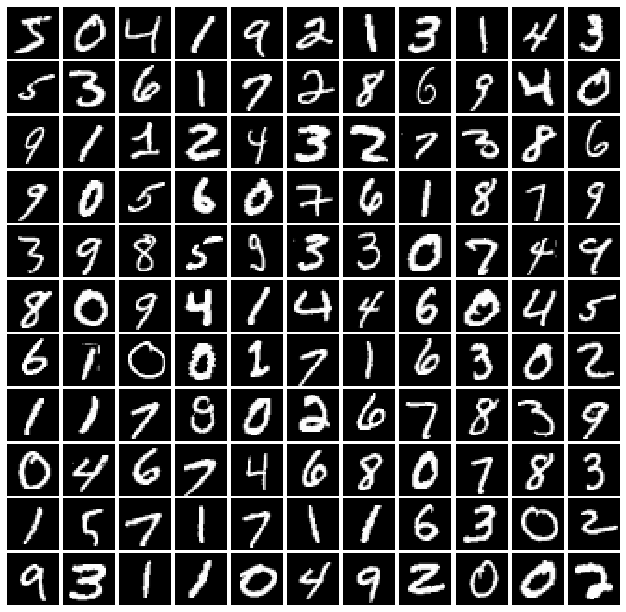

In [8]:
imgs = loader_train.__iter__().next()[0]
imgs = imgs.view(batch_size, 784).numpy().squeeze()

show_images(imgs[:121])
plt.show()

---
### b. Preprocess Image

`preprocess_img()` function is used to preprocess MNIST dataset images by normalizing it to range of $-1..1$

and another `deprocess_img()` function to return the image back to range of $0..1$

In [0]:
def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

---
### c. Relative Error Function

Function to calculate difference between your matrix and our expected results

In [0]:
def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

---
### d. Model Summary

Function to display model graph and count its number of parameters 

Kind of a simple version of keras `.summary()` in PyTorch

In [0]:
def count_params(model):
    param_count = np.sum([np.prod(p.size()) for p in model.parameters()])

    base = str(model).split('\n')
    base = base[1:-1]
    # base[-1] ="(-) : Output()"
    summary = []
    for layer in base:
        new_l = []
        layer = layer.replace('in_features=','')
        layer = layer.replace('out_features=','')
        layer = layer.replace('kernel_size','f')
        layer = layer.replace('=(','=[')
        layer = layer.replace('), ','], ')
        layer = layer.replace('momentum','m')
        layer = layer.replace('stride','s')
        layer = layer.replace('padding','p')
        layer = layer.replace('))','])')
        layer = layer.replace(', dilation=1, ceil_mode=False','') 
        layer = layer.replace('negative_slope','alpha') 
        layer = layer.replace(', affine=True, track_running_stats=True','') 
        layer = layer.split(': ')
        new_l.append(layer[0].replace(' ',''))
        new_l.extend(layer[1].replace('(','\n(').split('\n'))
        summary.append(new_l)
        
    params = []
    for param in model.parameters():
        params.append(np.prod(param.size()))
    
    i = 0
    for s in summary:
        if s[1] in ['Linear', 'BatchNorm1d', 'BatchNorm2d', 'Conv2d', 'ConvTranspose2d' ]:
            s.append(params[i]+params[i+1])
            i+=2

    line = "{: ^4} {:>15}  {:>40} {:>10}".format("ID", "Layer (type)", "Input-Output Shape", "Param #")
    print(line)
    print("=========================================================================")    
    for s in summary:
        if(len(s)<4):
            s.append('-')
        line = "{: >4} {:>15}  {:>40} {:>10}".format(*s)
        print(line)

    # print(model)
    print('\nTotal Parameters: {:,.0f}'.format(param_count))


---
### e. Flatten and Unflatten

Recall way back in our Task 08 Exercise?

There, we provide you with Flatten operation.

<br>


This time we also provide an **Unflatten** operation, which reshape an input vector into a 3-dimensional tensor.

You'll it use when implementing the convolutional generator. 


In [0]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
    


An Unflatten module receives an input of shape $(N, C^*H^*W)$ and reshapes it to produce an output of shape $(N, C, H, W)$.

In [0]:
class Unflatten(nn.Module):
    def __init__(self, N=-1, C=128, H=7, W=7):
        super(Unflatten, self).__init__()
        self.N = N
        self.C = C
        self.H = H
        self.W = W
        
    def forward(self, x):
        return x.view(self.N, self.C, self.H, self.W)


---
### f. Xavier Weight Initializer


We also provide a weight initializer (and call it for you) that uses Xavier initialization instead of PyTorch's uniform default.

In [0]:
def initialize_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
        init.xavier_uniform_(m.weight.data)

---
### g. Generate GIF

This function generate a GIF animation from the saved images and display it to your notebook

In [0]:
def show_gif(base_dir, anim_file): 

    with imageio.get_writer(anim_file, mode='I') as writer:
        filenames = glob.glob(base_dir+'/image*.png')
        filenames = sorted(filenames)
        for filename in filenames:
            image = imageio.imread(filename)
            for i in range(3):
              writer.append_data(image)
        image = imageio.imread(filename)
        writer.append_data(image)

    print('GIF saved as', anim_file)

    with open(anim_file,'rb') as f:
      display(Image(data=f.read(), format='png'))

---
## 5 - Load File Checker

we also provided a reference matrix to check whether the matrix produced by your implementation matched our expected output

In [0]:
!wget -q 'https://github.com/CNN-ADF/Task2019/raw/master/resources/gan-checks.npz'

answers = dict(np.load('gan-checks.npz'))

---
---
# [Part 2] Vanilla GAN

For starter, let's build our Vanilla GAN using Normal Neural Network (Linear Layer, not Convolutional Layer)

After we build the training function for Vanilla GAN, for the other architecture, it's as simple as replacing the Loss and the Networks (Generator and Discriminator network).

---
## 1 - Random Noise

Similar to Variational Autoencoder from previous exercise, GAN Generator network generate an image from a input random vector, called `seed` or `noise`

It is preferable that the seed is uniformly distributed in range of $(-1..1)$

However, PyTorch only provides random uniform generator &nbsp;`torch.rand()`&nbsp; function which generate a PyTorch Tensor in range of $(0..1)$

So we need to define a function to scale and shift it to the desired range

---
#### <font color='red'>**EXERCISE:** </font>

complete the function generate uniform noise from $-1$ to $1$ with shape `[batch_size, dim]`.

Hint: use `torch.rand()`.

In [0]:
def sample_noise(batch_size, dim):

    # use torch.rand() to generate random matrix of shape (batch_size, dim) 
    # then scale and shift it to range (-1, 1).
    noise = (-1 - 1) * torch.rand(batch_size, dim) + 1
        
    return noise


Make sure noise is the correct shape and type:

In [24]:
torch.manual_seed(231)
batch_size = 3
dim        = 4

z = sample_noise(batch_size, dim)
np_z = z.cpu().numpy()
print(np_z)


[[ 0.87505  0.94126 -0.11507 -0.79962]
 [ 0.52444 -0.3785  -0.45648  0.93903]
 [-0.3668   0.26815  0.44411  0.90036]]


**Expected Output**:
<pre>
[[-0.87505066 -0.9412632   0.11506891  0.799615  ]
 [-0.52444327  0.3785026   0.45648217 -0.93902993]
 [ 0.36680496 -0.26814795 -0.44410968 -0.9003619 ]]

---
## 2 - Discriminator Model
Our first step is to build a discriminator. Fill in the architecture as part of the `nn.Sequential` constructor in the function below. All fully connected layers should include bias terms. 

The architecture is:
<pre>
    * <b>Flatten</b> layer 
    * <b>Fully connected</b> layer with input size <font color='blue'><b>784</b></font> and output size <font color='blue'><b>256</b></font>,
    * <b>LeakyReLU</b> activation with alpha <font color='blue'><b>0.01</b></font> 
    * <b>Fully connected</b> layer with input size <font color='blue'><b>256</b></font> and output size <font color='blue'><b>256</b></font>,
    * <b>LeakyReLU</b> activation with alpha <font color='blue'><b>0.01</b></font> 
    * <b>Fully connected</b> layer with input size <font color='blue'><b>256</b></font> and output size <font color='blue'><b>1</b></font>,
</pre>


Recall Leaky ReLU:
  * Leaky ReLU nonlinearity computes&nbsp; $f(x) = \max(\alpha x, x)$ &nbsp;for some fixed constant $\alpha$; 
  * for this architecture, we set&nbsp; $\alpha=0.01$.
 
 <br>
 
The output of the discriminator should have shape `[batch_size, 1]`, and contain real numbers corresponding to the scores that each of the `batch_size` inputs is a real image.


---
#### <font color='red'>**EXERCISE:** </font>
Build and return a PyTorch model implementing the architecture above.

In [0]:
def discriminator():
    model = nn.Sequential(
        
        # add Flatten() custom layer        
        Flatten(),
        
        # add .Linear() layer from nn module with defined size, 
        nn.Linear(in_features=784, out_features=256),
        
        # add .LeakyRelu() from nn Module with defined alpha, 
        nn.LeakyReLU(), # default alpha = 0.01
        
        # add .Linear() layer from nn module with defined size, 
        nn.Linear(in_features=256, out_features=256),
        
        # add .LeakyRelu() from nn Module with defined alpha, 
        nn.LeakyReLU(), # default alpha = 0.01
        
        # add .Linear() layer from nn module with defined size, 
        nn.Linear(in_features=256, out_features=1)
    )
    return model

Test to make sure the number of parameters in the discriminator is correct:

In [26]:
model = discriminator()

count_params(model) 

 ID     Layer (type)                        Input-Output Shape    Param #
 (0)         Flatten                                        ()          -
 (1)          Linear                     (784, 256, bias=True)     200960
 (2)       LeakyReLU                              (alpha=0.01)          -
 (3)          Linear                     (256, 256, bias=True)      65792
 (4)       LeakyReLU                              (alpha=0.01)          -
 (5)          Linear                       (256, 1, bias=True)        257

Total Parameters: 267,009


**Expected Result**:
<pre>
 ID     Layer (type)               Input-Output Shape    Param #
================================================================
 (0)         Flatten                               ()          -
 (1)          Linear            (784, 256, bias=True)     200960
 (2)       LeakyReLU                     (alpha=0.01)          -
 (3)          Linear            (256, 256, bias=True)      65792
 (4)       LeakyReLU                     (alpha=0.01)          -
 (5)          Linear              (256, 1, bias=True)        257

Total Parameters: 267,009

---
## 3 - Generator Model

Now to build the generator network


The architecture is:
<pre>
    * <b>Flatten</b> layer 
    * <b>Fully connected</b> layer with input size <font color='blue'><b>noise_dim</b></font> and output size <font color='blue'><b>1024</b></font>,
    * <b>ReLU</b> activation
    * <b>Fully connected</b> layer with input size <font color='blue'><b>1024</b></font> and output size <font color='blue'><b>1024</b></font>,
    * <b>ReLU</b> activation
    * <b>Fully connected</b> layer with input size <font color='blue'><b>1024</b></font> and output size <font color='blue'><b>784</b></font>,
    * <b>TanH</b> activation
</pre>

---
#### <font color='red'>**EXERCISE:** </font>
Build and return a PyTorch model implementing the architecture above.

In [0]:
def generator(noise_dim=NOISE_DIM):
    """
    Build and return a PyTorch model implementing the architecture above.
    """
    model = nn.Sequential(
        
        # add .Linear() layer from nn module with defined size, 
        nn.Linear(in_features=noise_dim, out_features=1024),
        
        # add .Relu() activation from nn Module
        nn.ReLU(),
        
        # add .Linear() layer from nn module with defined size, 
        nn.Linear(in_features=1024, out_features=1024),
        
        # add .Relu() activation from nn Module
        nn.ReLU(),
        
        # add .Linear() layer from nn module with defined size, 
        nn.Linear(in_features=1024, out_features=784),
        
        # add .Tanh() activation from nn Module
        nn.Tanh()
    )
    return model

Test to make sure the number of parameters in the generator is correct:

In [28]:
model = generator(4)

count_params(model) 

 ID     Layer (type)                        Input-Output Shape    Param #
 (0)          Linear                      (4, 1024, bias=True)       5120
 (1)            ReLU                                        ()          -
 (2)          Linear                   (1024, 1024, bias=True)    1049600
 (3)            ReLU                                        ()          -
 (4)          Linear                    (1024, 784, bias=True)     803600
 (5)            Tanh                                        ()          -

Total Parameters: 1,858,320


**Expected Result**:
<pre>
 ID     Layer (type)                 Input-Output Shape    Param #
==================================================================
 (0)          Linear               (4, 1024, bias=True)       5120
 (1)            ReLU                                 ()          -
 (2)          Linear            (1024, 1024, bias=True)    1049600
 (3)            ReLU                                 ()          -
 (4)          Linear             (1024, 784, bias=True)     803600
 (5)            Tanh                                 ()          -

Total Parameters: 1,858,320

---
---
# [Part 3] GAN Loss

Compute the generator and discriminator loss. 

The generator loss is:

$$
\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]
$$

and the discriminator loss is:

$$ 
\ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]
$$

<br>

**Note** that these are negated from the equations presented earlier as we will be ***MINIMIZING*** these losses.

<br>

Instead of computing the expectation of $\log D(G(z))$, $\log D(x)$ and $\log \left(1-D(G(z))\right)$, 

we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing.

---
## 1 - Binary Cross Entropy

To compute the log probability of the true label given the logits output from the discriminator, we need to calculate the Binary Cross Entropy Loss.

Given a score $s\in\mathbb{R}$ and a label $y\in\{0, 1\}$, the binary cross entropy loss is

$$ bce(s, y) = -y * \log(s) - (1 - y) * \log(1 - s) $$

<br>

A naive implementation of this formula can be numerically unstable, so we have provided a numerically stable implementation for you below.

**Note: consult this [link](https://github.com/pytorch/pytorch/issues/751)*



In [0]:
def bce_loss(input, target):

    neg_abs = - input.abs()
    
    loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
    
    return loss.mean()

---
## 2 - Data Type conversion

You will also need to compute labels corresponding to real or fake and use the logit arguments to determine their size. This computation will be performed in your selected device (CPU or GPU).

If you are using GPU to train the network, you need to cast these labels to the correct data type using the global `dtype` variable, for example:

```python
      true_labels = torch.ones(size).type(dtype)
```

---
## 3 - Discriminator Loss
Discriminator Loss calculate the total loss of Discriminator Model in recognizing real images and fake images.

The loss formula is as follow:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

or in simple term:

```python
      loss = loss_real + loss_fake
```

where 
* `loss_real` is the binary cross entropy loss result between `logits_real` and `ones` matrix,

* while `loss_fake` is the binary cross entropy loss result between `logits_fake` and `zeros` matrix.

---
#### <font color='red'>**EXERCISE:** </font>

Implement the Discriminator Loss as  described above.

In [0]:
def discriminator_loss(logits_real, logits_fake):
    
    # get size of batch data
    N = logits_real.size(0)
    
    # create ONES tensor as real label
    # use torch.ones() with size N, remember to cast the type 
    labels_real = torch.ones(N).type(dtype)
    
    # calculate the loss_real using provided bce_loss() function
    # with input logits_real and labels_real
    loss_real = bce_loss(logits_real, labels_real)
    
    # create ZEROS tensor as fake label
    # use torch.zeros() with size N, remember to cast the type 
    # see example implementation above
    labels_fake = torch.zeros(N).type(dtype)
    
    # calculate the loss_fake using provided bce_loss() function
    # with input logits_fake and its labels_fake
    loss_fake = bce_loss(logits_fake, labels_fake)
    
    # calculate the total discriminator loss
    loss = loss_real + loss_fake
        
    return loss

Test your discriminator loss. 

You should see errors < `1e-7`.

In [31]:
d_loss = discriminator_loss(torch.Tensor(answers['logits_real']).type(dtype),
                            torch.Tensor(answers['logits_fake']).type(dtype)).cpu().numpy()

difference = rel_error(answers['d_loss_true'], d_loss)

print("Maximum error in d_loss: %g" % difference)


Maximum error in d_loss: 2.83811e-08


**Expected Result**:
<pre>
Maximum error in d_loss: 2.83811e-08

---
## 4 - Generator Loss

Generator Model is trained to *fool* the Discriminator. It means that we want to maximize the log probability when predicting fake images.

Thus, the Generator Loss is calculated using a simple Binary Cross Entropy as follow:

$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$

the `loss` calculates the binary cross entropy loss result between `logits_fake` and `ones` matrix

---
#### <font color='red'>**EXERCISE:** </font>

Implement the Generator Loss as  described above.

In [0]:
def generator_loss(logits_fake):
    
    # get the number of batch data using .size(0)
    N = logits_fake.size(0)
    
    # create ONES tensor as fake label
    # use torch.ones() with size N, remember to cast the type 
    labels_fake = torch.ones(N).type(dtype)
    
    # calculate the loss using provided bce_loss() function
    # with input logits_fake and its labels_fake
    loss = bce_loss(logits_fake, labels_fake)
    
    return loss

Test your generator and discriminator loss. You should see errors < 1e-7.

In [35]:
g_loss = generator_loss(torch.Tensor(answers['logits_fake']).type(dtype)).cpu().numpy()

difference = rel_error(answers['g_loss_true'], g_loss)

print("Maximum error in g_loss: %g" % difference)


Maximum error in g_loss: 3.4188e-08


**Expected Result**:
<pre>
Maximum error in g_loss: 3.4188e-08


---
---
# [Part 4] Training Function

---
## 1 - Adam Optimizer

To train our models, we will optimize it using Adam optimizer with a `1e-3` learning rate, beta1=`0.5`, beta2=`0.999`.

Note that training a model in PyTorch requires an [Optimizer](https://pytorch.org/docs/stable/optim.html) object to perform the step and weights update. 

For that, we need two optimizers for each generator and discriminator models. And later, we need another four when we implement LS-GAN and DC-GAN. We set all of them use the same Adam optimizer with the same learning rate and betas.

Therefore, rather than defining each of optimizers one-by-one, let's build a function to get the optimizer for any given model. We'll use this to construct optimizers for the generators and discriminators for the rest of the notebook.


---
#### <font color='red'>**EXERCISE:** </font>

Construct and return an Adam optimizer for the model with `learning rate = 1e-3` and `betas = (0.5, 0.999)`.

In [0]:
def get_optimizer(model):

    # call optim.Adam() function with input model.parameters() 
    # and defined learning rate and betas
    optimizer = optim.Adam(model.parameters(), lr=1e-3, betas=(0.5, 0.999))
    
    return optimizer

---
## 2 - Training Loop Function

We provide you the main training loop... you won't need to change this function,

but we **DO** encourage you to read through and understand it. 

In [0]:
def train_gan(Discriminator, Generator, base_dir,
              show_every=250, batch_size=128, noise_size=96, num_epochs=10):
    """
    Train a GAN!
    
    Inputs:
    - Discriminator  : Tuple of Discriminator package, containing:
      - D_model      : PyTorch models for the discriminator 
      - D_solver     : torch.optim Optimizers for training 
      - D_loss       : Functions to use for computing the discriminator loss.

    - Generator      : Tuple of Generator package, containing:
      - G_model      : PyTorch models for the generator 
      - G_solver     : torch.optim Optimizers for training 
      - G_loss       : Functions to use for computing the generator loss.

    - base_dir           : Directory to save the generated image example
    - show_every         : Show and save samples after every show_every iterations.
    - batch_size         : Batch size to use for training.
    - noise_size         : Dimension of the noise to use as input to the generator.
    - num_epochs         : Number of epochs over the training dataset to use for training.
    """

    # unpack Discriminator
    D_model, D_solver, D_loss = Discriminator

    # unpack Generator
    G_model, G_solver, G_loss = Generator

    # parameter setting
    iter_count = 0
    img_count  = 0
    seed_saved = sample_noise(batch_size, noise_size).type(dtype)

    # make directory for saving image
    if os.path.exists(base_dir):
        shutil.rmtree(base_dir)
    os.mkdir(base_dir)

    # start training
    for epoch in range(num_epochs):
        for x, _ in loader_train:
            if len(x) != batch_size:
                continue
            
            # reset the gradients
            D_solver.zero_grad()
            
            # get real images
            real_data   = x.type(dtype)
            logits_real = D_model(2* (real_data - 0.5)).type(dtype)

            # 1. GENERATOR NETWORK FORWARD
            # generate new fake images
            g_fake_seed = sample_noise(batch_size, noise_size).type(dtype)
            fake_images = G_model(g_fake_seed).detach()
            logits_fake = D_model(fake_images.view(batch_size, 1, 28, 28))


            # 2. DISCRIMINATOR NETWORK FORWARD
            # forward fake and real logits to discriminator
            d_total_error = D_loss(logits_real, logits_fake)
            
            
            # 3. DISCRIMINATOR NETWORK BACKWARD
            # backward the error
            d_total_error.backward() 

            # update discriminator weights
            D_solver.step()


            # 4. GENERATOR NETWORK BACKWARD            
            # reset the gradients
            G_solver.zero_grad()

            # generate new fake images
            g_fake_seed = sample_noise(batch_size, noise_size).type(dtype)
            fake_images = G_model(g_fake_seed)

            # get logits fake throuch discriminator network
            gen_logits_fake = D_model(fake_images.view(batch_size, 1, 28, 28))

            # calculate generator loss
            g_error = G_loss(gen_logits_fake)

            # backward the error
            g_error.backward()

            # update generator weights
            G_solver.step()

            if (iter_count % show_every == 0):

                print('Iter: {}, D loss: {:.4}, G loss:{:.4}'.format(iter_count,d_total_error.item(),g_error.item()))

                # show randomly generated images from this iteration
                imgs_numpy = fake_images.data.cpu().numpy()
                show_images(imgs_numpy[0:16])
                plt.show()

                # save images generated from the same initial seed
                # to visualize the generator progress along training
                filename = base_dir+'/image_'+'{:03}'.format(img_count)+'.png'
                fake_images = G_model(seed_saved)                
                imgs_numpy = fake_images.data.cpu().numpy()
                show_images(imgs_numpy[0:16])
                plt.savefig(filename)
                plt.close()
                print()
                img_count += 1

            iter_count += 1

    print('training done')


---
## 3 - Train Vanilla GAN

Well, that's it

Now let's try to train a Vanilla GAN!

Iter: 0, D loss: 1.328, G loss:0.7205


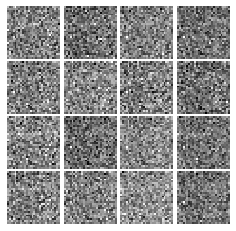


Iter: 250, D loss: 1.178, G loss:0.7702


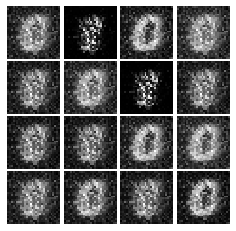


Iter: 500, D loss: 0.9595, G loss:1.243


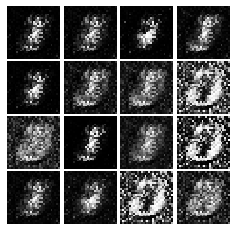


Iter: 750, D loss: 1.191, G loss:1.287


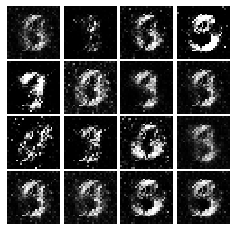


Iter: 1000, D loss: 1.036, G loss:1.181


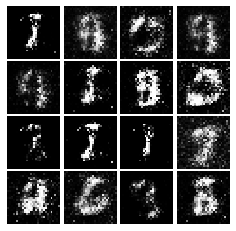


Iter: 1250, D loss: 1.105, G loss:0.9584


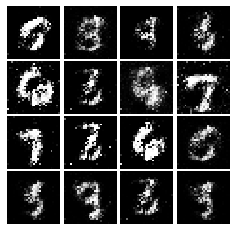


Iter: 1500, D loss: 1.281, G loss:0.7214


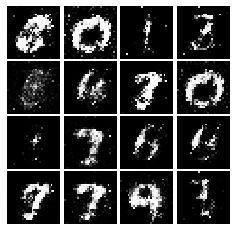


Iter: 1750, D loss: 1.27, G loss:0.7893


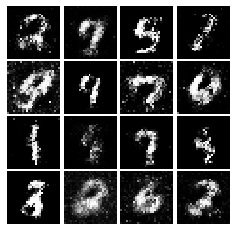


Iter: 2000, D loss: 1.248, G loss:0.9186


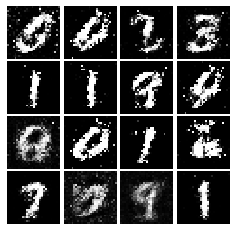


Iter: 2250, D loss: 1.343, G loss:0.9236


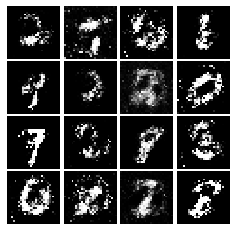


Iter: 2500, D loss: 1.293, G loss:0.8427


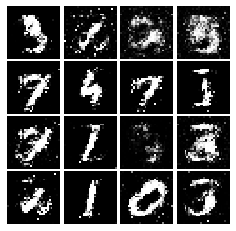


Iter: 2750, D loss: 1.322, G loss:0.8415


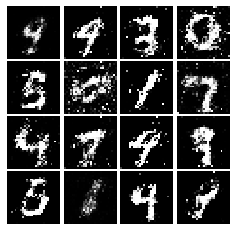


Iter: 3000, D loss: 1.325, G loss:0.7469


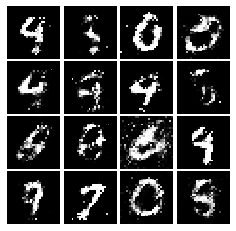


Iter: 3250, D loss: 1.249, G loss:0.9462


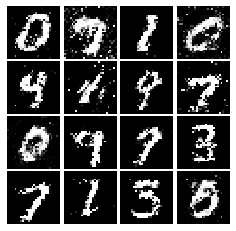


Iter: 3500, D loss: 1.31, G loss:0.8178


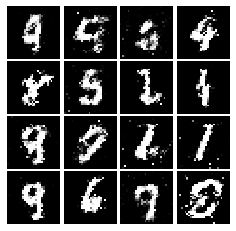


Iter: 3750, D loss: 1.37, G loss:0.9858


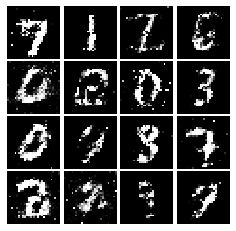


training done


In [38]:
# Make the discriminator
D_V = discriminator().type(dtype)

# Make the generator
G_V = generator().type(dtype)

# Use the function you wrote earlier to get optimizers for the Discriminator and the Generator
D_solver = get_optimizer(D_V)
G_solver = get_optimizer(G_V)

# pack the model
D = ( D_V, D_solver, discriminator_loss )
G = ( G_V, G_solver, generator_loss )

# Run it!
base_dir = 'v_gan'
train_gan(D, G, base_dir)


Well that wasn't so hard, was it? In the iterations in the low 100s you should see black backgrounds, fuzzy shapes as you approach iteration 1000, and decent shapes, about half of which will be sharp and clearly recognizable as we pass 3000.

---
## 4 - Generate GIF

Now this just for fun, we combine the saved image generated from the same initial seed each epoch while training into a GIF animation

In [39]:
base_dir = 'v_gan'

show_gif(base_dir, 'vanilla_gan.gif')

Output hidden; open in https://colab.research.google.com to view.

---
---
# [Part 5] Least Squares GAN
We'll now look at [Least Squares GAN](https://arxiv.org/abs/1611.04076), a newer, more stable alernative to the original GAN loss function. 

For this part, all we have to do is change the loss function and retrain the model. 

<br>

We'll implement equation (9) in the paper, with the generator loss:
$$
\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$

and the discriminator loss:

$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]
$$

---
## 1 - LS-Discriminator Loss

In <font color='red'>**Vanilla GAN**</font>, the Discriminator Loss is the total <font color='red'>binary cross entropy loss</font> from discriminator when recognizing real images and fake images. And we train the network to **MINIMIZE** that total loss

<br>

In <font color='blue'>**LS-GAN**</font>, we change the BCE loss calculation into a simple <font color='blue'>score averaging</font>. 

The idea is that since the Discriminator is a binary classification, it means that:

* we want the `real_score` when predicting **real images** to be **as close to 1 as possible**,

* and the `fake_score` when prediction **fake images** to be **as close to 0 as possible**.

<br>

Now if we ***flip*** the real scores by subtracting it with 1, this equalize our objectives so that now we want both `fake_score` and `real_score-1` to be as close to 0 as possible. And if we square the scores, now the values are always positive, and our objectives all become <font color='blue'>**minimization to 0**</font>.

<br>

As so we can just simply average the squared scores, and train the network to **MINIMIZE** the average

Thus we have:

$$
\ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]
$$

or its just simply,

```python
    loss_real = mean( square( scores_real-1 ) )
    loss_fake = mean( square( scores_fake ) )

    loss = 0.5 * loss_real + 0.5 * loss_fake
```

However, instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing. 

When plugging in for $D(x)$ and $D(G(z))$ use the direct output from the discriminator (`scores_real` and `scores_fake`).

---
#### <font color='red'>**EXERCISE:** </font>

Implement the Least Squares GAN Discriminator loss

In [0]:
def ls_discriminator_loss(scores_real, scores_fake):

    # calculate loss_real, 
    # first calculate the square of (scores_real-1)
    # then average the squared score by using torch.mean() 
    loss_real = torch.mean((scores_real-1)**2)
    
    # calculate loss_fake, 
    # use torch.mean() with input square of (scores_fake)
    loss_fake = torch.mean(scores_fake)
    
    # average the loss_real and loss_fake
    loss = loss_real - loss_fake

    return loss

Before running a GAN with our new loss function, let's check it:

You should see error <`1e-7`

In [58]:
score_real = torch.Tensor(answers['logits_real']).type(dtype)
score_fake = torch.Tensor(answers['logits_fake']).type(dtype)

d_loss = ls_discriminator_loss(score_real, score_fake).cpu().numpy()

difference = rel_error(answers['d_loss_lsgan_true'], d_loss)

print("Maximum error in d_loss: %g" % difference)


Maximum error in d_loss: 0.256863


**Expected Result**:
<pre>
Maximum error in g_loss: 1.53171e-08


---
## 2 - LS-Generator Loss

Similar to Vanilla GAN, Generator Loss is designed to minimize the correct classification of discriminator in predicting fake images. 

Before we use BCE loss, now in LS-GAN, since the Discriminator is using simple mean square error, then we have to treat the Generator the same way.

Thus our objective for Generator Model is to maximize the `fake_score` to be as close to 1 as possible, or flip it to minimizing `fake_score-1` to be as close to 0 as possible

And so we have:

$$
\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]
$$

or in simply, 
```python
    loss = 1/2 * mean( square( scores_fake-1 ) )
```


---
#### <font color='red'>**EXERCISE:** </font>

Implement the Least Squares GAN Generator loss

In [0]:
def ls_generator_loss(scores_fake):
    
    # calculate generator loss,
    # first use torch.mean() with input square of (scores_fake-1)
    # then divide by 2
    loss = torch.mean((scores_fake-1)**2) / 2

    return loss

Before running a GAN with our new loss function, let's check it:

You should see error <`1e-7`

In [60]:
score_real = torch.Tensor(answers['logits_real']).type(dtype)
score_fake = torch.Tensor(answers['logits_fake']).type(dtype)

d_loss = ls_discriminator_loss(score_real, score_fake).cpu().numpy()
g_loss = ls_generator_loss(score_fake).cpu().numpy()

g_difference = rel_error(answers['d_loss_lsgan_true'], d_loss)
d_difference = rel_error(answers['g_loss_lsgan_true'], g_loss)

print("Maximum error in d_loss: %g" % g_difference)
print("Maximum error in g_loss: %g" % d_difference)



Maximum error in d_loss: 0.256863
Maximum error in g_loss: 2.7837e-09


**Expected Result**:
<pre>
Maximum error in d_loss: 1.53171e-08
Maximum error in g_loss: 2.7837e-09


---
## 3 - Train LS-GAN
Run the following cell to train your model!

---
#### <font color='red'>**EXERCISE:** </font>

Complete the code to train LS-GAN

See the implementation in training Vanilla GAN for example

Iter: 0, D loss: 1.369, G loss:0.5517


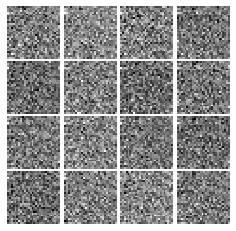


Iter: 250, D loss: -0.7062, G loss:0.1245


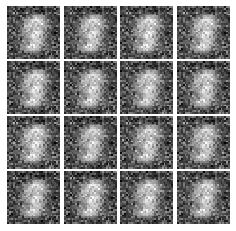


Iter: 500, D loss: -1.145, G loss:0.1794


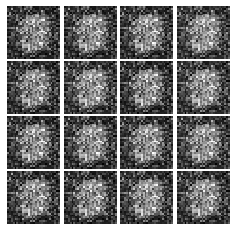


Iter: 750, D loss: -1.333, G loss:5.581


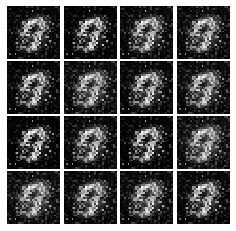


Iter: 1000, D loss: -1.419, G loss:0.7586


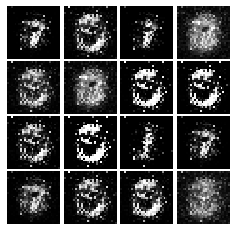


Iter: 1250, D loss: -1.769, G loss:0.2634


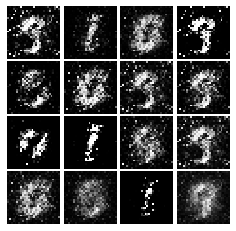


Iter: 1500, D loss: -1.414, G loss:0.4242


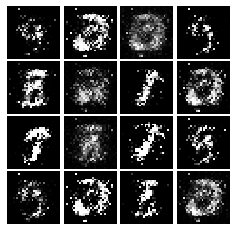


Iter: 1750, D loss: -1.456, G loss:0.5656


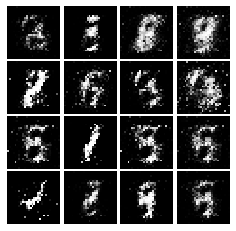


Iter: 2000, D loss: -1.382, G loss:0.287


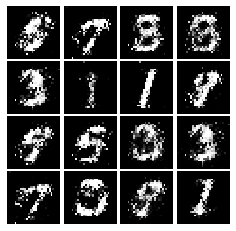


Iter: 2250, D loss: -1.28, G loss:0.2793


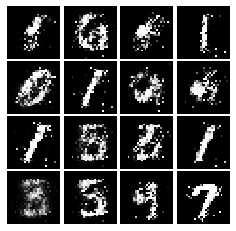


Iter: 2500, D loss: -1.31, G loss:0.3521


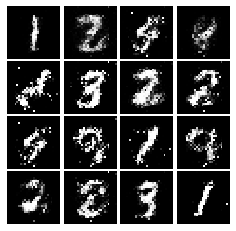


Iter: 2750, D loss: -1.375, G loss:0.4418


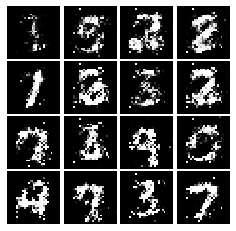


Iter: 3000, D loss: -1.337, G loss:0.3505


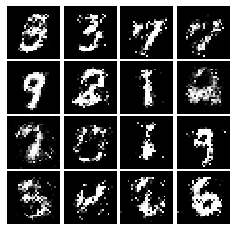


Iter: 3250, D loss: -1.369, G loss:0.283


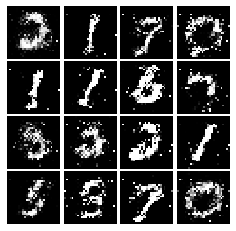


Iter: 3500, D loss: -1.271, G loss:0.268


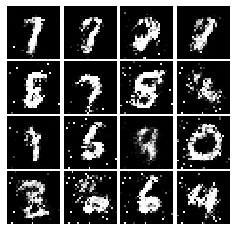


Iter: 3750, D loss: -1.319, G loss:0.224


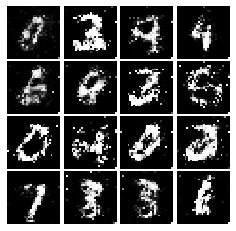


training done


In [61]:
# Make new discriminator model
# call discriminator() function, then cast the type
D_LS = discriminator().type(dtype)

# Make new generator model
# call generator() function, then cast the type
G_LS = generator().type(dtype)

# Use the get_optimizer() function to get optimizers for the Discriminator and the Generator
D_LS_solver = get_optimizer(D_LS)
G_LS_solver = get_optimizer(G_LS)

# pack the model into tuple
# pack D_LS, D_LS_solver, and ls_discriminator_loss into a single tuple
D = ( D_LS, D_LS_solver, ls_discriminator_loss )

# pack G_LS, G_LS_solver, and ls_generator_loss into a single tuple
G = ( G_LS, G_LS_solver, ls_generator_loss )


# train the networks by calling train_gan() function
base_dir = 'ls_gan'
train_gan(D, G, base_dir)


You should see that using LS-GAN, the generated image looks more sharp and clearly recognizable compared to Vanilla GAN.

---
## 4 - Generate GIF

Now this just for fun, we combine the saved image generated from the same initial seed each epoch while training into a GIF animation

In [62]:
base_dir = 'ls_gan'

show_gif(base_dir, 'ls_gan.gif')

Output hidden; open in https://colab.research.google.com to view.

---
---
# [Part 6] Deeply Convolutional GANs
In the first part of the notebook, we implemented an almost direct copy of the original GAN network from Ian Goodfellow. 

However, this network architecture allows no real spatial reasoning. It is unable to reason about things like "sharp edges" in general because it lacks any convolutional layers. 

Thus, in this section, we will implement some of the ideas from [DCGAN](https://arxiv.org/abs/1511.06434), where we use convolutional networks 

---
## 1 - DC-Discriminator Model

We will use a 4 layer ConvNet as our Discriminator Network 

The architecture is as follow:<pre>
    01. <b>Unflatten</b> layer       to reshape input into <font color='blue'><b>(1,28,28)</b></font> 
    02. <b>Conv2D</b> layer          with <font color='blue'><b>32</b></font> filters of <font color='blue'><b>5x5</b></font> using stride <font color='blue'><b>1</b></font>,
    03. <b>LeakyReLU</b> activation  with alpha <font color='blue'><b>0.01</b></font> 
    04. <b>Max Pool</b> layer        with kernel size of <font color='blue'><b>2x2</b></font> 
    05. <b>Conv2D</b> layer          with <font color='blue'><b>64</b></font> filters of <font color='blue'><b>5x5</b></font> using stride <font color='blue'><b>1</b></font>,
    06. <b>LeakyReLU</b> activation  with alpha <font color='blue'><b>0.01</b></font> 
    07. <b>Max Pool</b> layer        with kernel size of <font color='blue'><b>2x2</b></font> 
    08. <b>Flatten</b> layer         to reshape activation into vector
    09. <b>Fully Connected</b>       with input size <font color='blue'><b>4\*4\*64</b></font> and output size also <font color='blue'><b>4\*4\*64</b></font>,
    10. <b>LeakyReLU</b> activation  with alpha <font color='blue'><b>0.01</b></font> 
    11. <b>Fully Connected</b>       with input size <font color='blue'><b>4\*4\*64</b></font> and output size <font color='blue'><b>1</b></font>,
</pre>

---
RTFM: Read the [Documentation](https://pytorch.org/docs/stable/nn.html)

---
#### <font color='red'>**EXERCISE:** </font>
Build and return a PyTorch model implementing the architecture above.

Note: 

[.Conv2d()](https://pytorch.org/docs/stable/nn.html#conv2d) layer from .nn module receive required input as follow:
<pre>
* in_channel  : input channel dimension
* out_channel : output channel dimension (number of filter)
* kernel_size : either integer or tuple
* stride      : optional argument, default=1</pre>

while [.MaxPool2d()](https://pytorch.org/docs/stable/nn.html#maxpool2d) layer only receive required input as follow:
<pre>
* kernel_size : either integer or tuple
* stride      : optional argument, default equal to kernel_size</pre>

In [0]:
def dc_discriminator():
  
    return nn.Sequential(
        # 01. call Unflatten() function with input N=batch_size, C=1, W=28, and H=28
        Unflatten(N=batch_size, C=1, W=28, H=28),
        
        # 02. add Conv2d() from .nn module with 32 Filters, 5x5 kernel, Stride 1 
        # (from input channel = 1)
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(5,5), stride=1),
        
        # 03. add Leaky ReLU from .nn module with alpha=0.01
        nn.LeakyReLU(), # default alpha = 0.01
        
        # 04. add MaxPool2d from .nn module with kernel size 2x2, Stride 2
        nn.MaxPool2d(kernel_size=(2,2), stride=2),
        
        # 05. add Conv2d from .nn module with 64 Filters, 5x5 kernel, Stride 1 
        # (from input channel = 32)
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5), stride=1),
        
        # 06. add Leaky ReLU from .nn module with alpha=0.01
        nn.LeakyReLU(), # default alpha = 0.01
        
        # 07. add MaxPool2d from .nn module with kernel size 2x2, Stride 2
        nn.MaxPool2d(kernel_size=(2,2), stride=2),
        
        # 08. add Flatten function
        Flatten(),
        
        # 09. add Linear layer from .nn module
        # with both input and output size 4 x 4 x 64
        nn.Linear(in_features=4*4*64, out_features=4*4*64),
        
        # 10. add Leaky ReLU from .nn module with alpha=0.01
        nn.LeakyReLU(), # default alpha = 0.01
        
        # 11. add Linear layer from .nn module
        # with input 4 x 4 x 64 and output 1
        nn.Linear(in_features=4*4*64, out_features=1)
        
    )


Test to make sure the number of parameters in the discriminator is correct:

In [66]:
model = dc_discriminator()

count_params(model) 

 ID     Layer (type)                        Input-Output Shape    Param #
 (0)       Unflatten                                        ()          -
 (1)          Conv2d               (1, 32, f=[5, 5], s=[1, 1])        832
 (2)       LeakyReLU                              (alpha=0.01)          -
 (3)       MaxPool2d                      (f=[2, 2], s=2, p=0)          -
 (4)          Conv2d              (32, 64, f=[5, 5], s=[1, 1])      51264
 (5)       LeakyReLU                              (alpha=0.01)          -
 (6)       MaxPool2d                      (f=[2, 2], s=2, p=0)          -
 (7)         Flatten                                        ()          -
 (8)          Linear                   (1024, 1024, bias=True)    1049600
 (9)       LeakyReLU                              (alpha=0.01)          -
(10)          Linear                      (1024, 1, bias=True)       1025

Total Parameters: 1,102,721


**Expected Result**:
<pre>
 ID     Layer (type)                      Input-Output Shape    Param #
=======================================================================
 (0)       Unflatten                                      ()          -
 (1)          Conv2d             (1, 32, f=[5, 5], s=[1, 1])        832
 (2)       LeakyReLU                            (alpha=0.01)          -
 (3)       MaxPool2d                         (f=2, s=2, p=0)          -
 (4)          Conv2d            (32, 64, f=[5, 5], s=[1, 1])      51264
 (5)       LeakyReLU                            (alpha=0.01)          -
 (6)       MaxPool2d                         (f=2, s=2, p=0)          -
 (7)         Flatten                                      ()          -
 (8)          Linear                 (1024, 1024, bias=True)    1049600
 (9)       LeakyReLU                            (alpha=0.01)          -
(10)          Linear                    (1024, 1, bias=True)       1025

Total Parameters: 1,102,721

Now try to feed an input image and check the output shape

In [67]:
batch_size = 128

data = next(enumerate(loader_train))[-1][0].type(dtype)
print('Data shape   :', data.shape)

b   = dc_discriminator().type(dtype)
out = b(data)
print('Output shape :', out.size())

Data shape   : torch.Size([128, 1, 28, 28])
Output shape : torch.Size([128, 1])


**Expected Result**:
<pre>
Data shape   : torch.Size([128, 1, 28, 28])
Output shape : torch.Size([128, 1])


---
## 2 - DC-Generator Model
For the generator, we will copy the architecture exactly from the [InfoGAN paper](https://arxiv.org/pdf/1606.03657.pdf). 

The architecture is as follow:<pre>
    01. <b>Fully connected</b>  with input size <font color='blue'><b>noise_dim</b></font> and output size <font color='blue'><b>1024</b></font>,
    02. <b>ReLU</b> activation
    03. <b>BatchNorm1D</b>      with input size <font color='blue'><b>1024</b></font>
    04. <b>Fully connected</b>  with input size <font color='blue'><b>1024</b></font> and output size <font color='blue'><b>128\*7\*7</b></font>,
    05. <b>ReLU</b> activation
    06. <b>BatchNorm1D</b>      with input size <font color='blue'><b>128\*7\*7</b></font>
    07. <b>Unflatten</b> layer  to reshape activation into <font color='blue'><b>(128,7,7)</b></font> 
    08. <b>Conv2DTranspose</b>  with <font color='blue'><b>64</b></font> filters of <font color='blue'><b>4x4</b></font> using stride <font color='blue'><b>2</b></font>, and <font color='blue'><b>padding 1</b></font>
    09. <b>ReLU</b> activation
    10. <b>BatchNorm2D</b>      with input size <font color='blue'><b>64</b></font>
    11. <b>Conv2DTranspose</b>  with <font color='blue'><b>1</b></font> filters of <font color='blue'><b>4x4</b></font> using stride <font color='blue'><b>2</b></font>, and <font color='blue'><b>padding 1</b></font>
    12. <b>TanH</b> activation
    13. <b>Flatten</b> layer    to reshape activation into <font color='blue'><b>784</b></font> vector    
</pre>

---
RTFM: Read the [Documentation](https://pytorch.org/docs/stable/nn.html)

<font size=3><b> Something Weird? </b></font>

Note that the architecture reshape back it's already made output image of $(1,28,28)$ into a vector if $(784,)$

*weird, huh?*

<br>

Well, we need to reshape it back since we made our training function to receive and save images from a vector-shaped output from the previously Vanilla GAN

Since we don't want to change the training function just for this DC-GAN, it's easier to design the generator model to just return a vector

---
#### <font color='red'>**EXERCISE:** </font>
Build and return a PyTorch model implementing the architecture above.

In [0]:
def dc_generator(noise_dim=NOISE_DIM):

    return nn.Sequential(
        
        # 01. add Linear() with input noise_dim and output 1024
        nn.Linear(in_features=noise_dim, out_features=1024),
        
        # 02. add ReLU()
        nn.ReLU(),
        
        # 03. add BatchNorm1d() with input 1024
        nn.BatchNorm1d(1024),
        
        # 04. add Linear() with input 1024 and output 7*7*128
        nn.Linear(in_features=1024, out_features=7*7*128),
        
        # 05. add ReLU() from .nn module
        nn.ReLU(),
        
        # 06. add BatchNorm1d() with input 7*7*128
        nn.BatchNorm1d(7*7*128),
        
        # 07. add Unflatten() with input N=batch_size, C=128, W=7, and H=7
        Unflatten(N=batch_size, C=128, W=7, H=7),
        
        # 08. add ConvTranspose2d() with input channel = 128, 64 Filters, 
        # 4x4 kernel, stride 2, and padding 1 
        nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=(4,4), 
                           stride=2, padding=1),
        
        # 09. add ReLU() from .nn module
        nn.ReLU(),
        
        # 10. add BatchNorm2d() with input 64
        nn.BatchNorm2d(64),
        
        # 11. add ConvTranspose2d() with input channel = 64, 1 Filter, 
        # 4x4 kernel, stride 2, and padding 1 
        nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=(4,4), 
                           stride=2, padding=1),
        
        # 12. add Tanh() from .nn module
        nn.Tanh(),
        
        # 13. add back Flatten() 
        Flatten()
        
    )


Test to make sure the number of parameters in the discriminator is correct:

In [69]:
model = dc_generator(4)

count_params(model) 

 ID     Layer (type)                        Input-Output Shape    Param #
 (0)          Linear                      (4, 1024, bias=True)       5120
 (1)            ReLU                                        ()          -
 (2)     BatchNorm1d                  (1024, eps=1e-05, m=0.1)       2048
 (3)          Linear                   (1024, 6272, bias=True)    6428800
 (4)            ReLU                                        ()          -
 (5)     BatchNorm1d                  (6272, eps=1e-05, m=0.1)      12544
 (6)       Unflatten                                        ()          -
 (7) ConvTranspose2d   (128, 64, f=[4, 4], s=[2, 2], p=[1, 1])     131136
 (8)            ReLU                                        ()          -
 (9)     BatchNorm2d                    (64, eps=1e-05, m=0.1)        128
(10) ConvTranspose2d     (64, 1, f=[4, 4], s=[2, 2], p=[1, 1])       1025
(11)            Tanh                                        ()          -
(12)         Flatten                  

**Expected Result**:

<pre>
 ID     Layer (type)                        Input-Output Shape    Param #
=========================================================================
 (0)          Linear                      (4, 1024, bias=True)       5120
 (1)            ReLU                                        ()          -
 (2)     BatchNorm1d                  (1024, eps=1e-05, m=0.1)       2048
 (3)          Linear                   (1024, 6272, bias=True)    6428800
 (4)            ReLU                                        ()          -
 (5)     BatchNorm1d                  (6272, eps=1e-05, m=0.1)      12544
 (6)       Unflatten                                        ()          -
 (7) ConvTranspose2d   (128, 64, f=[4, 4], s=[2, 2], p=[1, 1])     131136
 (8)            ReLU                                        ()          -
 (9)     BatchNorm2d                    (64, eps=1e-05, m=0.1)        128
(10) ConvTranspose2d     (64, 1, f=[4, 4], s=[2, 2], p=[1, 1])       1025
(11)            Tanh                                        ()          -
(12)         Flatten                                        ()          -

Total Parameters: 6,580,801

Now try to feed an input image and check the output shape

In [70]:
batch_size = 128

test_g_gan = dc_generator().type(dtype)
test_g_gan.apply(initialize_weights)

fake_seed   = torch.randn(batch_size, NOISE_DIM).type(dtype)
fake_images = test_g_gan.forward(fake_seed)

print('Output shape :',fake_images.size())

Output shape : torch.Size([128, 784])


**Expected Result**:
<pre>
Output shape : torch.Size([128, 784])


---
## 3 - Train DC-GAN
Run the following cell to train your model!

---
#### <font color='red'>**EXERCISE:** </font>

Complete the code to train DC-GAN

See the implementation in training Vanilla GAN for example

Iter: 0, D loss: 1.414, G loss:1.126


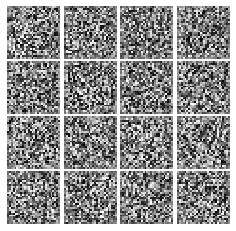


Iter: 250, D loss: 1.134, G loss:0.7068


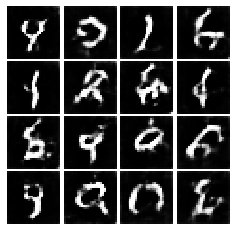


Iter: 500, D loss: 1.12, G loss:0.9599


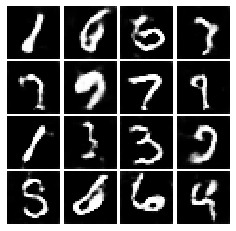


Iter: 750, D loss: 1.126, G loss:1.095


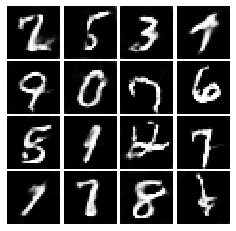


Iter: 1000, D loss: 1.219, G loss:1.11


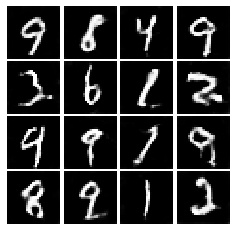


Iter: 1250, D loss: 1.207, G loss:0.8714


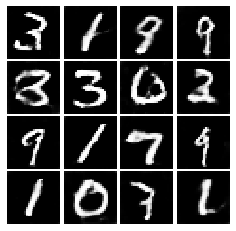


Iter: 1500, D loss: 1.103, G loss:1.22


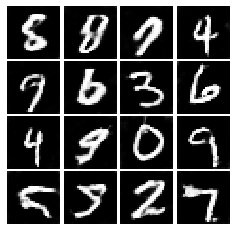


Iter: 1750, D loss: 1.071, G loss:0.7563


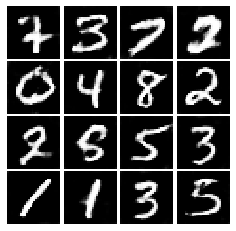


Iter: 2000, D loss: 1.317, G loss:0.8041


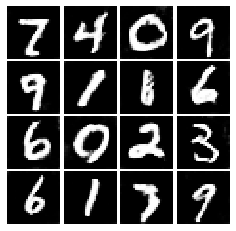


Iter: 2250, D loss: 1.118, G loss:1.189


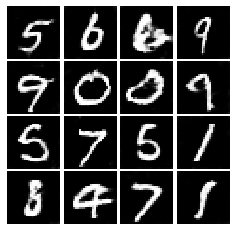


Iter: 2500, D loss: 1.086, G loss:1.108


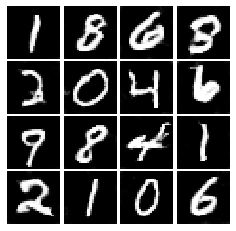


Iter: 2750, D loss: 1.006, G loss:1.171


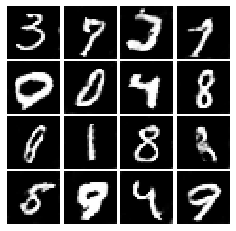


Iter: 3000, D loss: 1.057, G loss:0.8656


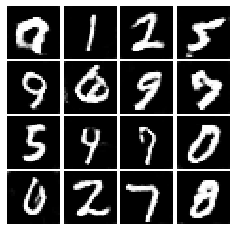


Iter: 3250, D loss: 1.033, G loss:1.17


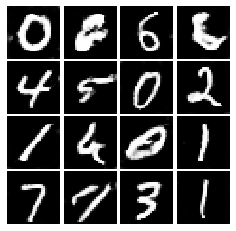


Iter: 3500, D loss: 1.045, G loss:1.262


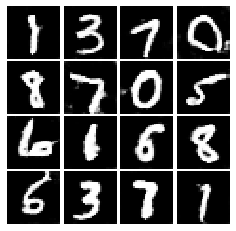


Iter: 3750, D loss: 0.977, G loss:1.283


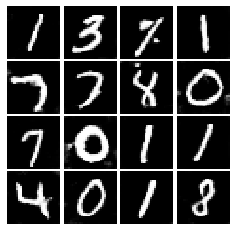


training done


In [71]:
# Make new discriminator model
# call dc_discriminator() function, then cast the type
D_DC = dc_discriminator().type(dtype)

# Make new generator model
# call dc_generator() function, then cast the type
G_DC = dc_generator().type(dtype)

# apply weight initialization
G_DC.apply(initialize_weights)
D_DC.apply(initialize_weights)


# Use the get_optimizer() function to get optimizers for the Discriminator and the Generator
D_DC_solver = get_optimizer(D_DC)
G_DC_solver = get_optimizer(G_DC)

# pack the model into tuple
# pack D_dc, D_dc_solver, and discriminator_loss into a single tuple
D = ( D_DC, D_DC_solver, discriminator_loss )

# pack G_dc, G_dc_solver, and generator_loss into a single tuple
G = (G_DC, G_DC_solver, generator_loss )


# train the networks by calling train_gan() function
base_dir = 'dc_gan'
train_gan(D, G, base_dir)


You should see that now using DC-GAN, from the start, the generated image looks much more clean and natural compared to using Linear GAN.

---
## 4 - Generate GIF

Now this just for fun, we combine the saved image generated from the same initial seed each epoch while training into a GIF animation

In [72]:
base_dir = 'dc_gan'

show_gif(base_dir, 'dc_gan.gif')

Output hidden; open in https://colab.research.google.com to view.

Pretty Neat, eh?

---
---
# [Part 7] Generate new Images

Let's see the result of our GAN with the same sample seed start

---
## 1 - Generate random noise


In [73]:
fake_seed = sample_noise(128, 96).type(dtype)

print(fake_seed.shape)

torch.Size([128, 96])


Example of seed of an image

In [74]:
print(fake_seed[0])

tensor([ 0.4877, -0.2914,  0.4317, -0.8046,  0.1841, -0.4872, -0.2851, -0.7071,
         0.8641,  0.7995,  0.3999, -0.1815,  0.6593, -0.7896,  0.7144,  0.3417,
        -0.6230, -0.7629, -0.4028, -0.4069, -0.6105, -0.7356, -0.6669,  0.0886,
        -0.4184, -0.7801, -0.8915,  0.2213,  0.0941, -0.9782, -0.4690, -0.0800,
        -0.4584,  0.4571,  0.8380,  0.9665,  0.3774,  0.7050, -0.7159, -0.1426,
         0.5856, -0.8570, -0.7971,  0.8338,  0.6921, -0.0771,  0.4464, -0.1536,
         0.7028,  0.4116,  0.1701,  0.9944,  0.2896, -0.7275, -0.6667,  0.8380,
        -0.6683, -0.8032, -0.1748, -0.4161,  0.5998,  0.2874, -0.3315,  0.8807,
        -0.8202,  0.4716,  0.7605, -0.2165,  0.0278, -0.7196,  0.3931,  0.3655,
        -0.9299, -0.9249,  0.7586,  0.2065,  0.1950,  0.1927,  0.2391, -0.8250,
        -0.7529,  0.1360, -0.4770,  0.4240,  0.4083, -0.8185, -0.9563, -0.4096,
        -0.3180, -0.8783,  0.4324,  0.8165,  0.0593,  0.5701,  0.4716, -0.0045],
       device='cuda:0')


---
## 2 - Vanilla GAN Generated Images

In [75]:
fake_images = G_V(fake_seed)

print(fake_images.shape)

torch.Size([128, 784])


View the generated images

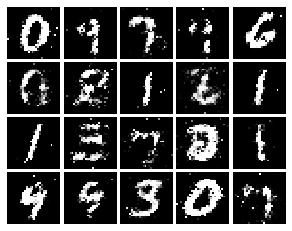

In [76]:
image_to_view = 20
imgs_numpy = fake_images.data.cpu().numpy()
show_images(imgs_numpy[0:image_to_view])
plt.show()

We can generate single image from a vector of fake seed

Vanilla GAN generated image
from seed tensor([-0.3472,  0.8527,  0.8733,  0.1146]) ...



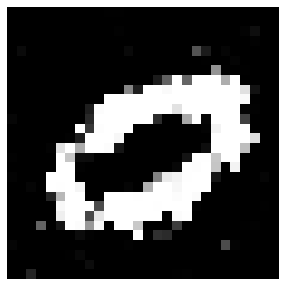

In [77]:
single_seed = sample_noise(1, 96)
print('Vanilla GAN generated image\nfrom seed', single_seed[0,:4],'...\n')

single_seed = single_seed.type(dtype)
fake_images = G_V(single_seed)
imgs_numpy = fake_images.data.cpu().numpy()

plt.figure(figsize=(5,5))
plt.imshow(imgs_numpy.reshape((28,28)))
plt.axis('off')
plt.show()


---
## 3 - Least Squares GAN Generated Images


In [78]:
fake_images = G_LS(fake_seed)

print(fake_images.shape)

torch.Size([128, 784])


View the generated images

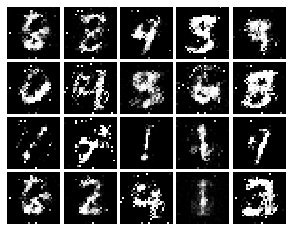

In [79]:
image_to_view = 20
imgs_numpy = fake_images.data.cpu().numpy()
show_images(imgs_numpy[0:image_to_view])
plt.show()

We can generate single image from a vector of fake seed

LS GAN generated image
from seed tensor([-0.6740, -0.6532,  0.7958,  0.6854]) ...



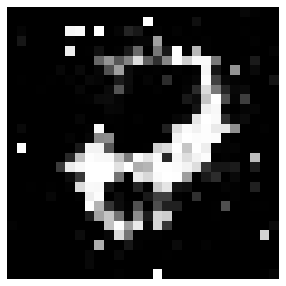

In [80]:
single_seed = sample_noise(1, 96)
print('LS GAN generated image\nfrom seed', single_seed[0,:4],'...\n')

single_seed = single_seed.type(dtype)
fake_images = G_LS(single_seed)
imgs_numpy = fake_images.data.cpu().numpy()

plt.figure(figsize=(5,5))
plt.imshow(imgs_numpy.reshape((28,28)))
plt.axis('off')
plt.show()


---
## 4 - Deep Convolutional GAN Images


In [81]:
fake_images = G_DC(fake_seed)

print(fake_images.shape)

torch.Size([128, 784])


View the generated images

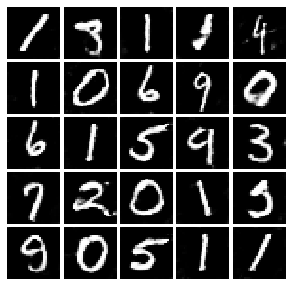

In [82]:
image_to_view = 25
imgs_numpy = fake_images.data.cpu().numpy()
show_images(imgs_numpy[0:image_to_view])
plt.show()

Looks great isn't it?

Now let's compare it to the real MNIST dataset

In [83]:
imgs = loader_train.__iter__().next()[0]
imgs = imgs.view(batch_size, 784).numpy().squeeze()
print(imgs.shape)

(128, 784)


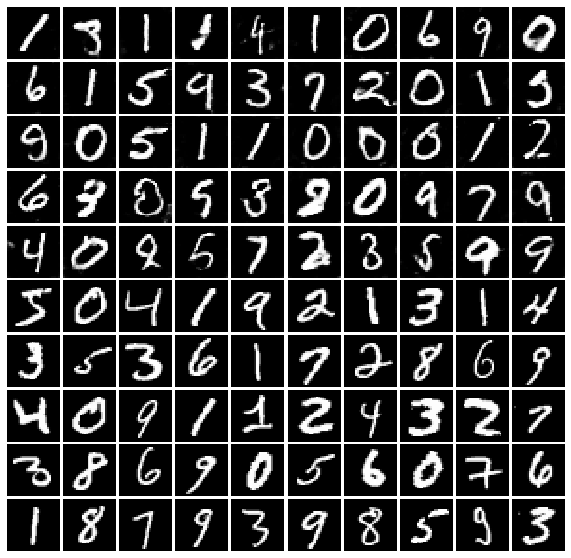

In [84]:
combined = np.vstack([imgs_numpy[:50,:], imgs[:50,:]])
idx = np.arange(combined.shape[0])
combined = combined[np.random.shuffle(idx)][0]
show_images(combined)
plt.show()

The images above are the combination between generated images and the real MNIST images.

Can you tell which is the original image and which is the fake one?

Can you tell the difference?



---
---

# Congratulation, You've Completed Exercise 16

![footer](https://image.ibb.co/hAHDYK/footer2018.png)